In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Love in the Time of Correlation
## Data-Driven Heartbreak on *The Good Place*

In [18]:
#How long it took Eleanor to figure out she wasn't in The Good Place
#max: 21 years
max = 21

#min: 1 years
min = 1

#average: 5 years
mu = 5

#total attempts: 802
pop_size = 802


#toy distribution just to look at 
dist = np.random.normal(loc = mu , scale = 1, size = (pop_size))

(array([  2.,   3.,   3.,  12.,  21.,  31.,  53.,  78.,  82., 103., 118.,
         99.,  68.,  59.,  31.,  18.,  10.,   4.,   3.,   4.]),
 array([1.84403565, 2.16287241, 2.48170918, 2.80054594, 3.11938271,
        3.43821947, 3.75705623, 4.075893  , 4.39472976, 4.71356653,
        5.03240329, 5.35124005, 5.67007682, 5.98891358, 6.30775035,
        6.62658711, 6.94542387, 7.26426064, 7.5830974 , 7.90193417,
        8.22077093]),
 <a list of 20 Patch objects>)

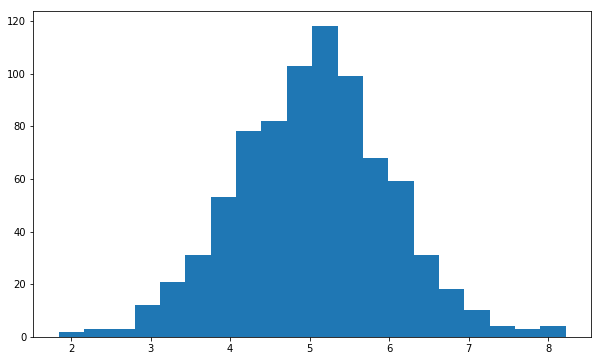

In [19]:
fig = plt.figure(figsize = (10,6))
plt.hist(dist, bins = 20)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


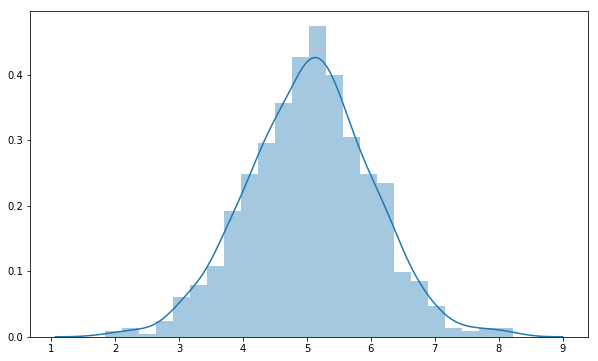

In [20]:
fig = plt.figure(figsize = (10,6))
sns.distplot(dist)

In [21]:
no_std_no_mean = np.random.randint(low = 11, high = 1000, size = 802)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


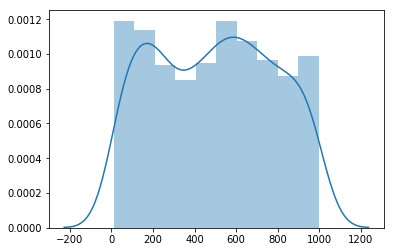

In [22]:
#looks binomial

sns.distplot(no_std_no_mean)


In [27]:
script = '''Eleanor? Come on in.
Hi, Eleanor.
I'm Michael.
How are you today? I'm great.
Thanks for asking.
Oh, one question.
Where am I? Who are you? And what's going on? Right, so, you, Eleanor Shellstrop, are dead.
Your life on Earth has ended, and you are now in the next phase of your existence in the universe.
Cool.
Cool.
I have some questions.
Thought you might.
[chuckles] How did I die? I-I don't remember.
Yes, um, in cases of traumatic or embarrassing deaths, we erase the memory to allow for a peaceful transition.
Are you sure you want to hear? All right, so you were in a grocery store parking lot.
You dropped a bottle of something called "Lonely Gal Margarita Mix for One.
" And when you bent down to pick it up, a long column of shopping carts that were being returned to the shopping cart collection area rolled out of control and plowed right into you.
Oof.
That's how I died? No, sorry, there's more.
You were able to grab on to the front of the column of shopping carts, but it swept you right out into the street where you were struck and killed by a mobile billboard truck advertising an erectile dysfunction pill called "Engorge-ulate.
" Funnily enough, the first EMT to arrive was an ex-boyfriend of yours Okay, that's I get it, thank you.
Oh, okay, sorry.
Um, so who was right? I mean about all of this? Well, let's see.
Hindus are a little bit right, Muslims a little bit.
Jews, Christians, Buddhists, every religion guessed about 5%, except for Doug Forcett.
Who who's Doug Forcett? Well, Doug was a stoner kid who lived in Calgary during the 1970s.
One night, he got really high on mushrooms, and his best friend, Randy, said, "Hey, what do you think happens after we die?" And Doug just launched into this long monologue where he got like 92% correct.
[chuckles] I mean, we couldn't believe what we were hearing.
That's him, actually, right up there.
He's pretty famous around here.
I'm very lucky to have that.
- So - [chuckles] Maybe my biggest question: am I I mean, is this Or Well, it's not the heaven or hell idea that you were raised on.
But generally speaking, in the afterlife, there's a Good Place and there's a Bad Place.
You're in the Good Place.
- [exhales sharply] - You're okay, Eleanor.
You're in the Good Place.
Well, that's good.
Sure is.
[laughs] Okay, let's take a walk, shall we? Oh, did I have a purse? No, I'm dead, right.
Okay.
So this is how it works.
The Good Place is divided into distinct neighborhoods.
Each one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance.
Do all the neighborhoods look like this? No, every neighborhood is unique.
Some have warm weather, some cold.
Some are cities, some farmland.
But in each one, every blade of grass, every ladybug, every detail has been precisely designed and calibrated for its residents.
There's a lot of frozen yogurt places.
Yeah.
[sighs] That's the one thing we put in all the neighborhoods.
People love frozen yogurt.
I don't know what to tell you.
You're gonna have a million more questions, I know.
For right now, better grab a seat.
Movie's about to begin.
[indistinct chatter] - Ah.
[chuckles] Hello, everyone.
- And welcome to your first day in the afterlife.
You were all, simply put, good people.
But how do we know that you were good? How are we sure? - During your time on Earth, - every one of your actions had a positive or a negative value, depending on how much good or bad that action put into the universe.
- Every sandwich you ate, - - every time you bought a magazine, - every single thing you did had an effect that rippled out over time and ultimately created some amount of good or bad.
You know how some people pull into the breakdown lane when there's traffic? And they think to themselves, "Ah, who cares? No one's watching.
" We were watching.
Surprise.
[laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.
Only the people with the very highest scores, the true cream of the crop, get to come here, to the Good Place.
What happens to everyone else, you ask? Don't worry about it.
The point is, you are here because you lived one of the very best lives that could be lived.
And you won't be alone.
Your true soul mate is here too.
- [crowd gasps and murmurs] - That's right.
Soul mates are real.
One of the other people in your neighborhood is your actual soul mate, and you will spend eternity together.
So welcome to eternal happiness.
Welcome to the Good Place.
Sponsored by: otters holding hands while they sleep.
You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.
[applause] So who is in the Bad Place, that would shock me? Uh, well, Mozart, Picasso, Elvis, basically every artist ever, uh, every U.
S.
president except Lincoln.
That sounds about right.
What about Florence Nightingale? That was close, but, no, she didn't make it.
Wow, all those amazing people down there, it just seems so hard to believe.
Again, it's an incredibly selective system.
Most people don't make it here.
But you, a lawyer who got innocent people off death row, you're special, Eleanor.
And by the way, welcome to your new home.
Oh, it's perfect, isn't it? You see, in the Good Place, every person gets to live in a home that perfectly matches his or her true essence.
Cool.
So I guess that's why my house, for example, is this adorable little cottage, whereas other people might have homes that are bigger, like that one.
Exactly.
Oh, I'm so happy you get it.
As you can see, the interior has been decorated just as you like it, in the Icelandic primitive style.
Oh, oh, and, uh, of course, you love clowns, so I do love clowns.
Now, let me show you the, uh the video system here.
[shimmering tone] You can review everything that happened in your life from your point of view.
There we go.
This is your Human Rights mission to the Ukraine.
I mean, you got a ton of points for that one.
It really put you over the top.
Oh.
Chidi, come on in.
Eleanor? I'm Chidi Anagonye, and you are my soul mate.
Cool, bring it in, man.
Now, excuse me.
I have other people to attend to.
So where you from, Chidi? Well, I was born in Nigeria, raised in Senegal, but my work took me all over the place Australia, Hong Kong, Paris.
What about you? Uh, well, I I was born in Phoenix.
- Mm-hmm.
- Arizona.
And then I went to school in Tempe, Arizona.
And then I moved back to Phoenix, Arizona.
Your English is amazing.
Oh! I'm actually speaking French.
This place just translates whatever you say into a language the other person can understand.
- So it's incredible.
- Whoa.
And now I want to say this.
Mm-kay.
Eleanor.
I have spent my entire life in pursuit of fundamental truths about the universe.
And now we can actually learn about them together as soul mates.
It's overwhelming.
Chidi.
You'll stand by my side no matter what, right? Of course I will.
Promise me.
Say, "I promise I will never betray you for any reason.
" Eleanor, I swear that I will never say or do anything to cause you any harm.
Good.
Because those aren't my memories.
I wasn't a lawyer.
I never went to the Ukraine.
I hate clowns.
There's been a big mistake.
I'm not supposed to be here.
Wait, what? [light instrumental music] [children chattering] Are you sure this isn't you? Yeah, man, I'm pretty sure I wasn't a death row lawyer who collected clown paintings and rescued orphans.
They got my name right, but nothing else.
I mean, somebody royally forked up.
Somebody forked up.
Why can't I say "fork"? If you're trying to curse, you can't here.
I guess a lot of people in this neighborhood don't like it, so it's prohibited.
That's bullshirt.
So, uh, if you're not this person, then who are you? What did you do for a living? I was in sales.
So we sell two products here, NasaPRO and NasaPRO Silver.
We aim this at seniors.
Now, you can't legally call it medicine because it doesn't technically work and it is technically chalk, so what you're gonna want to do You need me to lie to old people and scare them into buying fake medicine.
I get it, man.
Which one's my desk? So your job was to defraud the elderly? Sorry the sick and elderly? But I was very good at it.
I was the top salesperson five years running.
Okay, but that's worse.
I mean, you you do get how that's worse? - Right? - Mm.
[indistinct chatter] You know, maybe it's a test.
Maybe if you go to Michael and you tell him the truth, you'll pass the test and you'll get to stay.
No way.
I can't risk going to the Bad Place.
Okay, well, maybe it's not actually, like, all that bad.
Let's just get some information first.
We'll ask Janet.
Hey, Janet? - Hi there.
- Gah! How can I help you? What the fork? Who are you? I'm Janet.
I'm the informational assistant here in the Good Place.
She's like this walking database.
You can ask her about the creation of the universe or history Oh, there was a guy who lived in Avondale, Arizona, around 2002.
His name was Kevin Paltonic.
- Is he gay? - No.
Really? Huh.
I guess he just didn't want to have sex with me.
That's correct.
Well, that's fine, I wasn't that into him anyway.
- Yes, you were.
- Okay, Janet, - I have a question.
- Okay.
What is the Bad Place like? Oh, sorry, that is the one topic I'm not allowed to tell you about.
I can only play you a brief audio clip of what is happening there right now.
Okay.
[people yelling and screaming, mechanical buzzing] - The bear has two mouths! - [people screaming] [sound stops] Well, it doesn't sound awesome.
[scoffs] Does everyone have a huge house except me? All right, we need a plan.
I say we just lie low and hope that they don't notice me.
I'm sorry, I don't think I can help you.
I just don't like being dishonest, and I can't advise you to be dishonest either.
Come on, I'm just asking you to fudge a little bit.
You must've told a few white lies in your life.
I mean, what was your job? I was a professor of ethics and moral philosophy.
Motherforker! I'm getting a stomachache.
I'm in a perfect utopia, and I'm I have a stomachache.
This is awful.
I-I, uh I think I have to tell Michael about this.
Tell Michael about what? Michael? Hi.
What have you been up to? Eleanor, Chidi, I would like you to meet Tahani and Jianyu.
They are soul mates and your next-door neighbors.
Hello.
Can I just say I love your house? It's just so tiny and cute.
It's like a little child's plaything, like for a family of mice or for a very fancy little dog.
I love it.
It's just so sweet and teensy.
Just like you.
Boop.
- Oh.
- Oh.
You booped me.
Ha-ha.
- I did.
- That's fun.
Tahani and Jianyu are having a little welcome party tonight, and they've invited the entire neighborhood.
- [squeaks] - I simply adore entertaining.
Don't I just adore it, Jianyu? Oh, um, yes, by the way, Jianyu here is a Buddhist monk, you see? And he obeys a strict code of silence.
So when you see him smiling and nodding, that's actually his way of jumping up and down with glee.
Isn't that right, darling? So we'll see you tonight? - Great.
- Yes.
[indistinct chatter] - [scoffs] - No way.
[indistinct chatter] My entire house could fit in this room.
Okay, uh help me out here.
Tell me one good thing that you did on Earth, just one truly kind and decent act so that I can feel better about helping you out.
Let's forget about good.
Um, just tell me something neutral about yourself.
Like, tell me about the day before you died.
What do you remember? Hi there.
Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.
[scoffs] Pick it up if you're so horny for the environment.
I don't remember anything specific.
- Oh.
- Look.
I might not have been a saint, but it's not like I killed anybody.
I wasn't an arsonist.
I never found a wallet outside of an IHOP and thought about returning it but saw the owner lived out of state so just took the cash and dropped the wallet back on the ground.
Okay, that's really specific, and that makes me think that you definitely did do that.
All I'm saying is these people might be "good," but are they really that much better than me? Well, I spent half my life in North Korea fighting for women's rights and the other half in Saudi Arabia fighting for gay rights.
So we said, "If the U.
N.
won't remove those land mines, we will.
" And we dug up over a thousand unexploded land mines from the area surrounding the orphanage.
Well, then he said, "You can't give me both your kidneys; you'll die.
" And I said, "But you will live.
" And I know we just met on this bus ten minutes ago, but he seemed nice.
[groans] Oh, forget it.
Heading to the bar! [glass clinking] [polite applause] Thank you, thank you.
You all know that I am the architect of this neighborhood.
But what you don't know is Golly, I'm not supposed to tell you this, but, um, oh, what the heck? This is actually the very first neighborhood that I have ever designed.
I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.
- [murmurs and applause] - Yes! [laughs] Ah, gah-gah gah-gah-gah.
Hold on there, ace.
Let me get more of them shrampies.
- Okay, easy.
- What? They're for everybody, right? Yes, exactly.
And you deserve a perfect world because every single one of you is a good person.
That's it for me.
Back to you, Tahani.
- Bravo, Michael, bravo! - Thank you.
Um, and I would just like to quickly say if any of you would like to play tennis tonight, we have 36 regulation grass tennis courts.
Such fun.
Cheers.
[laughs] [applause] Tahani, what a condescending bench.
- Okay, okay, okay, okay.
- Am I right? Why does she still have that British accent, right? No one else here has an accent.
She's choosing to have that accent.
- Shh-shh-shh-shh.
- [stodgily] "Oh, hello.
"I am just a big, beautiful, utterly perfect cartoon giraffe.
" Oh, okay.
Okay.
- I think it's time to go home.
- [laughing mockingly] Wait, wait, wait.
I just have to go upstairs real quick and steal a bunch of gold stuff.
Okay, don't do that.
Don't do no, Eleanor, Eleanor, Eleanor.
[light instrumental music] Hello, creepy house that I hate.
Hello, one million clowns.
Why aren't there stairs here? [groans] What kind of weirdo house is this? Ooh.
Did you fill your bra with shrimp? No.
[hiccups] Yes.
Whatever, it's freakin' heaven.
I'm sure they have plenty of shellfish.
That Tahani is a real butthead, huh? [gasps] Hey.
At least I can still say "butthead.
" [groans] She is a butthead.
Found some pajamas.
Chidi Chidi, Chidi? I'm sorry that you had to deal with this It's okay.
It's not, though.
[sighs] Do you think anybody cared that I died? Maybe someone did.
I don't know.
I was an only child.
My parents were divorced when I was a kid.
They were both crummy people, so they're probably [imitates fart] in the Bad Place.
Maybe they're being used to torture each other.
It would work.
[chuckles] I bet way more people cared that you died.
'Cause you're a nice person.
[clears throat] You're a nice person, Chidi Anaconda.
Anagonye.
Aganocomonga.
Anagonye.
- Ags say it again.
- Anagonye.
No, say what you said before.
I did.
It's Anagonye.
You just changed it.
I didn't change it; it's my name.
Argrugande.
Ariana Grande.
[gasps] That's a person.
I did it.
Good night.
Good night.
[button clicks] [playful music] [people cheer] [playful musical flourish] Well, that's terrifying.
[snoring] [thunder crashes, birds cawing] [thunder crashing] That can't be good.
[pop music] I'm stronger than I've been before This is the part When I break free 'Cause I can't resist it no more Oh, fork.
The part when I say I don't want ya I'm stronger than I've been before This is the part When I break free 'Cause I can't resist it no more - Michael.
- Mm? Is that giant, terrifying ladybug supposed to be there? Ah, well, great question, Tahani.
No.
No, it's not.
I have no idea why any of this is happening or how to control it.
Should we run away then? Yes.
It was lethal - Righto.
- It was fatal In my dreams, it just felt so right But I woke up every time Ooh, baby This is the part When I say I don't want ya I'm stronger than I've been before Chidi, Chidi! What's going on? Why are there giant animals everywhere? Do you hear Ariana Grande playing? Why is everyone wearing blue and yellow? You're not.
You're you're the only one who's not.
Eleanor, this is all happening because of you.
Ah, fork me.
Okay, okay.
We don't know this is because of me.
Eleanor, this place is a perfectly made Swiss watch, and you are a wrench in the gears.
Actually, you're a hammer, just smashing the gears into dust.
Oh, hang on.
Not everybody here is perfect, okay? Tahani is totally condescending.
And there are a couple of, you know, chunksters.
Oh, come on! No judgment.
I'm just saying I'm not the only one with flaws.
So how can we be sure this is my fault? You hogged all the shrimp, and now there are shrimp flying around.
You called Tahani a giraffe, and now there are giraffes everywhere.
Okay, fine, turns out there are many ways to know that it was me.
Let's just face it, Eleanor, you don't belong here.
Well, then this system sucks.
What, one in a million gets to live in paradise and everyone else is tortured for eternity? Come on.
I mean, I wasn't freaking Gandhi, but I was okay.
I was a medium person.
I should get to spend eternity in a medium place! Like Cincinnati.
Everyone who wasn't perfect but wasn't terrible should get to spend eternity in Cincinnati.
Look, apparently it doesn't work that way.
I'm sorry, Eleanor, but there's nothing anyone can do.
Unless there is something we can do.
Unless you could teach me.
Teach you what? How to be good.
That was your job, right? A professor of ethics? No one knew I was a problem when I arrived.
Things only started getting crazy after I was an ash-hole to everyone at the party.
[groans] You know I'm trying to say "ash-hole" and not "ash-hole," right? I got that, yes.
Okay, give me a chance.
Let me earn my place here.
Let me be your ethical guinea pig.
[knock at door] Hey, guys! Uh, emergency neighborhood meeting, now! We'll be right there, Michael! If I walk out of here in these clothes, I'm toast.
My soul is in your hands, soul mate.
What's it gonna be? [knock at door] [thunder crashes] Oh, stomachache.
[mid-tempo music] I, uh I don't know what to do here.
This is a mess, morally speaking.
This is a putrid, disgusting bowl of ethical soup.
Okay, well how about we just chill and go to the town meeting and talk it out after? - W - Great.
Hey, how do I make that helper woman show up? Hello? Front desk lady? Magical slave robot? Excuse me, Janet? - Hi there.
- [gasps] Gah still not used to it.
Um, Janet, I need quick question: can anyone access our search history, or is this an incognito browsing situation like when you're stalking a hot male man from your work computer? It is 100% confidential.
No one can access what you ask me, including Michael.
Now, what kind of pornography would you like to see? No.
No, no, no, not porn.
I, um I need clothes like yours and Chidi's with the stripes.
There you go.
[indistinct chatter] [claps] Everybody, everybody! Uh, gather round, please, thank you, thank you.
Obviously, there's something very wrong with this neighborhood.
We don't know what it is, how long it will last, or what caused it.
What do we know, Janet? We know where it happened.
Here.
Yes, thank you, Janet.
The chaos happened here.
See, that's the trouble with these perfect systems.
One little flaw can lead to well, it can lead to Gary over there.
[indistinct murmuring] Hey, Gary.
Hang in there, buddy.
Boy, my armpits are leaking.
What is that called again? - Sweat.
- Right, right.
Still not used to being in a human body.
And what do you do with sweat? Do do you lick it away, is that right? No, you dab it with a cloth.
Oh, right.
And then you lick the cloth? That seems weirder.
Michael.
Look! Okay.
That's a good sign.
It it could mean that this is almost over.
Oh, such a relief.
That was my first time as a fashion "don't," and I did not care for it.
Okay, I think it is time to make me good, partner.
How do we do it? Is there a pill I can take or something I could vape? Where did you get a chalkboard? It's the Good Place; you can get anything you want at any time.
And you chose a chalkboard? What are you reading? "The Metaphysics of Morals" by Immanuel Kant.
It's a treatise on the aesthetic preconditions of the mind's receptivity to duty.
A book on how to act good.
Oh, great! So you've decided to help me? I don't know.
There's a thousand questions.
Is there a moral imperative to help you? Do I have a greater obligation to my community? Are you taking someone else's spot, someone who deserves to be here? Ooh, on that question, I honestly think I was just put here by mistake.
Because Michael called me Eleanor Shellstrop, so he knows I'm me.
He's just wrong about my overall "quality" level.
Please, help me, man.
I swear I am worth it.
Tell me one fact that you know about me.
I mean, we spent the whole day together.
You must remember something.
What country am I from? [groans] Is it racist if I say Africa? Yes, and Africa is not a country.
I am from Senegal.
Do I have any siblings? Where did I go to college? Trick question.
You didn't.
I was literally a college professor.
Do you not remember one single thing about me? Dude, things have been nuts around here.
I bet you don't know anything about me.
You were born in Phoenix.
You went to school in Tempe.
You're an only child.
Your favorite show is something called "The Real Housewives of Atlanta," and your favorite book is Kendall Jenner's Instagram feed.
How did you know all that? Because you are constantly talking about yourself.
You are the most self-obsessed person I have ever met.
You should see Kendall Jenner's Instagram feed.
Okay, this is my fear about you, Eleanor.
You are too selfish to ever be a good person.
Well, I think you're wrong.
What country am I from, again? Sen sodyne.
That is a brand of toothpaste.
Look, the only thing that you are concerned with is your own happiness.
That's your problem.
[scoffs] Okay, names in the hat.
Time to pick a designated driver.
And the loser is Betsy.
Wait, you never get picked, and you're always the one who draws the name.
- Let me see that.
- There's no need.
Everyone here believes in my integrity 100%, right, guys? Give it to me.
For the record, I did that out of principle, because it absolutely had your name on it.
If I check the other ones, I can figure it out by process of elimination.
[indistinct chatter] All right, everyone, let's get started.
Things have settled down.
Whew! [chuckles] So hopefully, we're off and running.
Welcome to orientation, day two.
Now, today we're gonna start with something that everyone has always wanted to do.
Flying.
[gasps and warm applause] Now that you're dead, let's live a little, right? Uh, sorry.
Uh, Michael? If if I might? I was just thinking, earlier today in all of the chaos, large swaths of this neighborhood were destroyed.
We thought perhaps some of us could, uh, volunteer to help clean up the debris.
You know, it's quite a fun way to band together as a community, isn't that right, Jianyu? Oh, uh, yeah, sorry.
For those of you who don't know, my soul mate, Jianyu here, is a Buddhist monk.
He took a vow of silence that he's still observing, even here, in the Good Place.
It's truly inspiring.
Well, Tahani, it's not really your job to clean up, but I suppose there's no harm if you really want to.
Oh, well, hurrah.
We need about, uh, 12 volunteers.
Oh! I can't believe all these people are passing on flying to pick up garbage all day.
[chuckles] Have fun, nerds.
I'll be soaring through the air like a forkin' bird.
Eleanor and I would love to help.
Ah, hurrah-hurrah, yay.
Dude.
You want to prove you're not selfish? Here's the perfect test.
There's something fun that you want to do, and then there's something less fun that people are doing for the common good.
Which do you choose? Have fun.
Whoo! [woman laughing] - Hey! - [people chattering] Yeah! Whee! Hey, up there, having fun, or does it maybe suck, probably? I'd say it's like 50 million simultaneous orgasms, but better.
How's volunteer garbage pickup? - About the same.
- Great! Whee! You know, this really reminds me of my time in Vietnam, picking up mortar shells with my godmother, Diana.
Doesn't really matter of what she's a princess of.
It's not really important.
Tahani! How goes the cleaning? Oh, swimmingly, Michael.
And I have to say this neighborhood that you've built is truly a masterpiece, the likes of which I've never seen.
And I've been to Johnny Depp's private bird sanctuary.
Well, thank you.
That's very kind of you to say.
[sniffs] But it's also dead wrong.
This neighborhood is a disaster.
See, I must have made a mistake somewhere.
[sniffs] And it led to all this chaos, and now I'm just I'm just terrified that it's gonna happen again.
I'm trying to put a good face on well, this this face that I've constructed for myself.
But the truth is, I I'm just miserable.
[sniffs] I have to go.
Thank you so much for your service.
Oh, no.
Powerful people do not handle failure well.
Michael could be heading for a total meltdown.
Soul mate, are you thinking what I'm thinking? Should we say it at the same time? All right.
One, two, three.
We must help Michael.
Oh, you sly devil.
You're going to keep me on my toes, aren't you? All right, come on.
Let's go.
[giggling] - Oh.
- Ooh.
Hey, Gunnar! Hey, Antonio! Hey, Eleanor.
- Isn't this great? - Um, yeah.
When I thought of the afterlife, I totally pictured being an unpaid, non-flying janitor.
Us too! [laughter] You guys are so fun.
Just relentlessly fun.
I keep thinking, "When are they gonna stop being fun?" And the answer is never.
- You're never gonna stop.
- [both giggling] Well, I have had a pretty full day of being unselfish.
I've made some new friends.
My area's almost garbage-free.
So you're gonna help me figure out how to stay, right? Well, that is a really tough question.
Most great philosophers would say helping you is pointless, that you can't try to be good, especially when your motivations are so obviously corrupt.
Yeah, but what do most great philosophers know? On the other hand, Aristotle thought that moral virtue is something that you could get better at.
He he compared it to playing the flute.
The more you practice, the more you improve.
Aristotle! That's my boy, right there.
He was the best.
I mean, most people agree he was the best one.
So it sounds to me like you are on board the "help Eleanor" train.
Well, I've narrowed it down to two possibilities: yes and no.
Well, no worries.
Just hit me up when you're done weighing my life in your hands.
I'll just keep doing what I do best: being super considerate and selfless.
[exhales] Hey, guys.
Okay, Eleanor, reminder.
We switched to a rotating system for choosing a designated driver, and it's your turn.
Got it.
Full disclosure, I forgot we were doing this new system.
I got off work early.
I've been here for about an hour, and I'm already pretty drunk.
Someone else will do it.
Good call.
Guess the only place I'll be driving is through the giant loophole in the system I accidentally discovered.
Beep! Beep! [laughs] [slurping] Whoo! - Whoa! - [people cheering] I can't believe they've managed to mix one million flavors together, and yet, somehow, I can taste each individual one.
It's remarkable.
I got no-flavor.
- It's all I deserve, really.
- No.
Look, I I appreciate you trying to cheer me up.
I really do, but you don't understand.
This was the very first neighborhood that I got to design.
It was my chance to prove myself, and now I've blown it.
You know, sometimes a flaw can make something even more beautiful, like with Cindy Crawford and how short she is.
Oh, Tahani, if I made one tiny mistake in my design, if there's a single glitch in the system, if even one blade of grass is angled a a fraction of a degree off [dog whimpers] The whole neighborhood is compromised.
Whose dog is that? Guys, whose dog is that? Whose dog is that? See, this is one of those glitches I was talking about.
Nice try, puppy! [dog whimpering] [dog whimpers, pop] Whew! [chuckles] That was a close one.
Teacup? Hey, have you seen my dog? [grunts] Shouldn't these be magical trash bags? Five more minutes, flyers! Five more minutes! Oh, man, really? [bright instrumental music] Janet, I'm finished with cleanup, and I'm ready to fly.
- How do I start? - Hop on the launch pad and conjure an image that brings you pure joy.
Some people think of their wedding day or favorite vacation spot.
People puking on roller coasters.
People puking on roller coasters.
[gasps] [laughs] It's working! Ow! What the fork? [thunder crashing] Janet, any chance this is a scheduled trash storm? So here's the situation, Pevita.
I kind of kicked your dog into the sun.
But I got her back.
- [dog whimpers and growls] - Everything everything seems fine.
Teacup, thank goodness you're okay.
Everyone, it is merely a construct of a dog.
It feels no pain or joy or love.
Teacup doesn't love me? Oh! Oh, no, no, no, no, no, it definitely feels love.
Do you actually want a dog that loves you a little bit more? Because I can kick her right back into the sun and get you another one just like that.
- No! - Oh, boy.
I'm making things worse.
Okay, all right, that's all right.
Breathe.
Breathe do you breathe? - Mm-hmm.
- If you do, then just breathe 'cause everything's fine, Michael, it's fine.
Ooh! [wind whistling] It's raining garbage.
Run! Ooh, ooh, no, no, no, I'm gonna run this way.
[garbage clattering] Chidi! Hey.
Before you say anything That's it, I just don't want you to say anything.
- What did you do? - Nothing! It just started raining trash out of nowhere for no reason at all.
- [thunder crashes] - [screams] Oh okay, fine, fine.
My bag broke, and I ditched the trash instead of taking it all the way to the dumpster.
But in my defense, there were only five minutes left in flying and I wanted to go flying.
How is that a defense? You made a bad choice.
I made a bad choice? We could have literally been flying, and all you wanted to do was talk about morals.
I mean, you're like the worst part of Superman.
This is a relief.
I can stop my deliberations.
You're a selfish person, and it is pointless to help you.
You are on your own.
Oh, man.
[laughing] How 'bout this trash storm, Gunnar? More cleaning up to do.
It's a it's a dream come true.
[gasps] [both exhale] We're okay! You can't die here.
Come on, I mean, even you have to admit, those guys are psycho.
I don't know what's happening to me.
I mean, it's my duty to be calm and in control and I'm falling apart.
No, Michael, you are a paragon of fortitude.
You're a mountain of strength.
I'm not a mountain of strength.
I'm a canyon full of poo-poo.
[sobbing] Jianyu, the architect of this neighborhood has just referred to himself as a canyon full of poo-poo.
Surely now, you will say something? Grace us with your vocalized wisdom.
Please, I'm begging you.
[gentle piano music] Oh.
Yes, yes, I understand.
The strength is inside me.
It's been there all along.
No, of course, I can overcome any obstacle.
Oh, thank you, Jianyu, thank you.
[laughs] I'm back.
You did it.
Oh, you have so much to teach me.
Maybe I should try to be silent too.
No really, look.
Here I go.
Oh! That was wonderful! So cleansing.
[eerie music] [laughter] Just water tonight, huh? Designated driver? Yeah, it sucks.
I think it's awesome.
I mean, someone's got to do it, right? I think it's a cool thing to do for people.
Yeah.
No no, I meant I meant I it sucks that I can't do it more often, you know? I actually prefer it to drinking.
Staying sober and knowing my friends will get home safe, that's my buzz.
Hey, guys, good news and bad news.
See that hot bartender over there? He's into me, and we're gonna bang it out.
The bad news is, it means I can't drive you guys home.
But I did call a cab for you guys.
But they recognized my number, and they didn't want to come.
I've thrown up in a lot of cabs.
So are we good here? Eleanor, you have a very important choice to make.
If you blow us off, you are banned from Thursday night drinks forever.
Yeah, I'm good with that.
I'll see you guys at work.
Peace! You, let's go.
[sighs] Hey.
How did you know I was here? I saw you from my window.
That's where I live, by the way.
Not that you ever asked.
What are you doing? I went to all the places where I dumped trash earlier and cleaned it up so it couldn't be traced back to me.
Well, it looks like you cleaned up everything.
You're doing this because you feel bad.
And you're not even doing it to get me to help you anymore because I told you that's not gonna happen.
Okay, yeah, fine, I felt bad for stupid Gunnar and stupider Antonio and the whole neighborhood.
I felt bad about what I did.
It was a weird feeling.
Not used to it.
Didn't love it.
Well, feeling remorse about being wrong isn't as good as just doing something right, but it's a start.
Look, I think you're capable of change.
And I will help you try.
Oh, wow, man, I swear I won't let you down.
Hi there.
I've collected the worst-smelling garbage that I could find.
Do you still want me to dump it inside of Antonio's house? What? No.
I did not tell you to do that.
You are loco, girlfriend.
Okay, I won't let you down starting now.
[chuckling] Ah, Eleanor.
- Good morning.
- Michael.
Do you know what the best part about this place is? You figured out how to make a to-go cup that doesn't leak right where the seam meets the lid.
Oh, I'm so glad you noticed.
I was very proud of that.
One of the hardest problems I had to solve.
Eleanor, I know what you did.
Cleaning up the entire neighborhood by yourself.
[laughs] I knew you were special, but this is proof.
Enjoy your coffee.
And the cup.
Okay, let's begin your "good person" lessons.
You got a long way to go to pull this off.
It will take hours and hours of studying ethics and moral philosophy.
We're gonna have assignments and quizzes and papers.
It's gonna be so much fun.
Remind me what I'm getting out of this again.
You get to avoid eternal damnation.
Oh, yeah.
Right.
Hey, I got you a present.
What? Senegal.
That's not a present; that's just common decency.
Yeah, but I forkin' nailed it.
Good talk.
[tense music] Ah, shirt.""
'''


In [29]:
lines = script.split('.')

In [30]:
lines_with_numerals = []
for line in lines:
    words = line.split()
    for word in words:
        if word.isdigit():
            lines_with_numerals.append(line)

In [31]:
lines_with_numerals

['\nEach one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance',
 '\nYou can ask her about the creation of the universe or history Oh, there was a guy who lived in Avondale, Arizona, around 2002',
 '\nI had been an apprentice for over 200 years, and my boss has finally given me my first solo project',
 '\nUm, and I would just like to quickly say if any of you would like to play tennis tonight, we have 36 regulation grass tennis courts',
 '\nWe need about, uh, 12 volunteers',
 "\nWhoo! [woman laughing] - Hey! - [people chattering] Yeah! Whee! Hey, up there, having fun, or does it maybe suck, probably? I'd say it's like 50 million simultaneous orgasms, but better"]

In [41]:
lines_with_spelled_numerals[2]

"\nYou know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day"

In [42]:
script2 = '''
1 I still believe that they would have become good people if they'd just gotten a push in the right direction.
[TENSE MUSIC] - Oh, no! - What are they talking about? - No idea.
- It's only four people, and it's clearly the best way to see if bad people can become good without knowing anything about what's waiting for them in the afterlife.
[GROANING] - Okay, let's do it.
- Yes! But there have to be strict rules.
Otherwise, the results will be tainted, and I reserve the right to change my mind at any point.
Would someone who's not an eternal being please explain to me what the f [TENTATIVE MUSIC] Hi, I'm Michael.
You must be The Doorman.
Ah.
This is wild.
I had no idea this was even here.
So I have this ruling from The Judge.
Heading on down to Earth to reverse the deaths of these four people.
It's kind of tricky, you know? It starts up a new timeline, so there might be some ripple effects.
But it's necessary for the experiment that we're doing there.
So, how long's this trip take? Hope I don't get a middle seat.
[SNAPS, CHUCKLES] Wow, I haven't heard a joke in 8,000 years.
And I still haven't.
That's the door to Earth.
You go through there, you'll be wherever you need to be.
You won't have any other powers, though.
You want to get around, you're just going to have to - take a bus or something.
- A bus? Oh, boy, oh, man! I'm going to sit in a front-facing seat.
Or or no, maybe a sideways-facing seat.
I'm I'm going to get so motion sick! Oh, man! What do I do, just grab that key here Whoa, whoa, whoa! This key is made of the very first atoms that came into existence in the universe.
It is one of a kind and cannot be duplicated.
See? "Do Not Duplicate.
" Only I touch this key.
Oh, and what's the significance of the keychain? Nothing, I just like frogs.
I'm a frog guy.
When you need to get back here, make sure you're alone.
Press this button.
Any questions? No? Great.
Knock yourself out.
[LIGHTLY TENSE MUSIC] Uh-oh.
[DRAMATIC MUSIC] I-I'm sorry, but this is an important moment - On your right, mate! - Oh, jeez, watch it, man! [YELLS] Come down! Come down where you belong.
[SCREAMS] Buongiorno.
Buongiorno.
[GROANS] Oh, wow! I was just on Earth.
It was incredible.
The the traffic, the pigeons.
And I saw this place that was, at once, a Pizza Hut and a Taco Bell! I mean, oh! The mind reels.
A Pizza Hut and a Taco Bell! Ah! [BRIGHT MUSIC] Oh, Janet, it was everything I ever imagined.
I got to ride a bike.
I put a coin in a thing and got a gumball.
And then someone came up to me and said, "Hot enough for ya?" And you know what I said? I said, "Tell me about it.
" [LAUGHS] Well, I am glad that you got to chew a gumball.
Oh, damn.
I didn't even think to chew it.
Missed opportunity, shoot.
Did you also save their lives? Yes, of course.
Everyone is safe.
Including Jason.
Now we just sit back and watch as they become better people.
Being good is for suckers.
What do you even get out of it? I quit.
Eat my farts, Benedict Cumberbatch.
[WHIMSICAL MUSIC] Morning, Chidi.
Blueberry muffin for ya? Uh, I don't know, maybe.
I can't decide.
- You all right there, mate? - Okay, I've made my decision.
I want to start crying.
[LOUD SOB] Hey, Tahani Al-Jamil.
I'm from "International Sophisticate Magazine.
" Mind if we ask you 582 questions? - Sounds delightful.
- Where are we, exactly? My pied-a-terre, just off the coast of "Barthelona.
" What's one thing people don't know about you? That I was such a tomboy in high school.
- See? - Wow! Looking good.
Okay, next question.
Who would you say is the most famous person in your phone? It's not about who you know.
Enlightenment comes from within.
The Dalai Lama texted me that.
K, will you make me the happiest man in the world, and agree to be my wife? No.
Do you think my name is the letter K? Just say yes.
If we're married, legally you can't arrest me.
Plus, bonus you get half the stuff I stole.
Yep, he just confessed to the robbery.
Damn it.
[EXHALES] You realize what the problem is, right? Yes, but there's no way to help.
Maybe there is.
In the afterlife, they all got better because they helped each other.
And the key to that was Chidi and Eleanor's connection.
If I get the two of them together, - everything else will follow.
- Michael, no.
I'm going to meet Eleanor someplace and plant the idea in her mind that she needs to find Chidi.
Oh, and then maybe I'll visit Chidi and make sure that he helps her when she shows up.
I'm just going to nudge the two of them together.
Just nudge-y nudge nudge.
The Judge was pretty clear in her instructions, and The Judge is, you know, The Judge of, you know, the universe.
She'll never find out.
She spends all her time in her chambers bingeing TV shows.
She's watching all of "NCIS" right now.
[SUSPENSEFUL MUSIC] Hey, there.
Need to head on back to Earth.
Travel papers.
Yeah.
You know, The Judge said to use the same ones.
Because I'm, uh, you know, visiting the same people.
Oh, yeah, I almost forgot.
I brought you a nice hot cup of antimatter.
I usually only drink decaf antimatter.
- Ah.
- Eh, I'll take it.
It's only 4:30.
My shift doesn't end until 9 billion.
Ooh.
- What do I owe ya? - The real question, Eleanor, is what do we owe to each other? What do we owe to each other? That is the question Tim Scanlon asked decades ago, and it is the question I will try to answer over the next three hours.
Are you Chidi Anna Kendrick? Anagonye, and yes.
Great, hi.
My name is Eleanor Shellstrop.
- Can we talk? - Sure.
Okay, uh, where do I start? I'm not, like, the best person in the world.
I'm a trash bag from Arizona, which is saying something.
Our biggest exports are racist sheriffs and HPV.
But about a year ago, something crazy happened [KNOCKING] And I [BOTH SPEAKING FRENCH] Sorry.
I've been flying for like, 40 hours.
This is Australia, right? Yes.
I grew up in Senegal, so my native language is French.
But I went to American schools, so I also speak English.
- Oh.
- And German and Greek.
And Latin, just in case it ever comes back.
Cool.
I once got 12 out of 12 on a Buzzfeed quiz called "Do you know all the slang words the Kardashians invented?" - Congratulations? - Thank you.
I'm going to be honest.
I did cheat.
But you were saying something crazy happened to you? Yes, uh, I almost died.
And it made me want to become a better person, which I did for a while.
But then I fell back into my old trash bag ways.
Yesterday, I saw your lecture, and something just clicked.
Wait, you flew all the way here from Arizona just to see me? You know what, don't flatter yourself, pal.
Sorry, that's a knee-jerk reaction.
Yes, that's exactly what I did.
And I know that seems zonk-atronic that's Khloe's word for crazy but I need someone to help guide me, morally speaking.
And I think I need it to be you.
What do you say? Will you help me become a good person? [SOFT MUSIC] - Yes.
- [CHUCKLES] [INHALES] I'll start you off with some introductory philosophy books, and then we'll meet here once a week.
Great.
Ideally, some of those books will have been made into a movie or maybe a funny GIF.
But anything's good with me, man.
- Can I ask you something? - Mm-hmm.
Why are you helping me? I'm a teacher.
That's my job.
Yeah, but I'm not your student.
I'm just some hot rando who walked in off the street.
There's got to be another reason.
Yes, there is.
Um I also had a near-death experience.
- Whoa.
- Well, I mean, I don't know for sure that I would have died, but, it was pretty nuts.
I'm sorry, but this is an important moment in our friendship - On your right, mate! - Oh, jeez.
Watch it, man! [YELLS] Oh, my God.
Are you okay? That that is right where I was standing.
I was frozen here, unable to make a single decision, and I almost got crushed by an air conditioner.
This is a sign.
I shouldn't be using air conditioners.
The freon is awful for the environment.
That's the lesson you take from this? Chidi, your brain is broken.
You need to fix your brain.
So in a nutshell, I have a 3,600-page thesis that I am nowhere near finishing, I am absolutely paralyzed by decision-making, and it is destroying my life.
Yeah, I sort of got that when you couldn't choose a chair to sit on.
Well, I didn't want to offend you in case you had a favorite.
Look, I know I just kind of nope walked in here, and you don't know me at all, but is there any way to tell if my indecision is due to a brain thing? Um, yeah, sure.
Now what we do is we make a lengthy incision from your eyebrows to the nape of your neck, and we peel your face back, right, then slice your skull open.
And I just randomly stab at your brain with an electrified needle.
The fun part is you're awake the whole time.
Uh I'm kidding! I'll just give you an MRI and look at the part of your brain that controls decision-making.
Oh, I want that.
I need to learn about my brain, please.
Well, so you just march into my office unannounced, tell me your brain is broken, then demand I drop everything and just put you in the university's $3 million MRI machine? Oh, I'm sorry, I just I freaking love it.
You're so weird! Let's go.
- Right now? - Oh, yeah, come on.
Oh okay.
[LIGHT MUSIC] This is your hippocampus.
It regulates memory.
Yours looks great, very strong.
Gorgeous hippocampus here! [BOTH LAUGH] This is your ventromedial prefrontal cortex, the center of decision-making.
This is where the magic happens.
Do you see how it's all lit up? That's a flurry of activity that occurred when I asked you to choose between red and blue, and you almost passed out.
Is it too late to pick blue instead? It is, yeah.
The point is, at first glance, your brain is very healthy.
Huh, there are actual answers here, data you can observe and learn from.
Yeah, man, science is all about getting answers.
You philosophers can spend your entire life mulling over a single questions.
That's why everyone hates moral philosophy professors.
- [LAUGHS] - No offense.
Oh, none taken.
We suck.
- Yeah.
- [BOTH LAUGH] [UPBEAT MUSIC] - Chidi.
- One blueberry muffin, please.
Why choose to be good every day? I argue that we choose to be good because of our bonds with other people.
Simply put, we are not in this alone.
Thank you.
[APPLAUSE] Wow, Chidi.
You chose that muffin in less than a minute.
That beats your old record by 59 minutes.
Henry, I feel amazing.
I am 100 pages into my new thesis, and it is some of the best writing that I have ever done.
I haven't been this happy since Oh, wow.
I've never been happy.
- Ha! - Bad! I'm proud of you, mate.
It must be really nice to live that way.
Well, that's the beauty of it.
Anyone can live this way.
Just decide to be more decisive.
Like, what's something that you've always wanted to do? I mean, I have been putting off getting in shape.
Then make the decision to wake up tomorrow morning and get in shape.
It is that easy.
Okay.
Maybe I will! - What have you got to lose? - Nothing! Henry, what happened to you? Well, I was using the leg press at the gym, and you know how your legs bend a certain way? My legs bend the other way now.
Oh, no.
All the tendons in my legs snapped like violin strings, and then, my foot flew forwards, and I kicked myself in the face, which gave me a concussion.
But on the bright side, I lost control of my bladder.
Someone got it on video, and now "Leg Press Whizzer" has 62,000 views on Youtube.
- I'm famous.
- This is all my fault.
I did this to you.
Oh oh, muffins! I brought blueberry muffins.
Oh, no, you shouldn't eat blueberries anymore.
Read an article.
The migrant workers who pick them are horribly mistreated.
Yaaaaaaah! [BRIGHT MUSIC] Good morning, Chidi.
Blueberry muffin for ya? Uh, I don't know, maybe.
I can't decide.
- You all right there, mate? - Okay, I've made my decision.
I want to start crying.
[WHEELS SQUEAK] [BRIGHT MUSIC] Excuse me? What is the maximum number of books that I can check out? - Is it 12,000? - Got a wild weekend planned? Well, I need to find a new topic for my thesis, and I had this thing happen that made me more decisive, and a few months ago, my friend broke both of his legs, and it's my fault, and blueberries, and I need help.
- Whoo! - Maybe that help will come from Tay Zonday's autobiography, "Chocolate Book.
" I mean, who's to say? Mate, I've worked in this library a long time, and I've seen a lot of academic types with that same helpless look on their faces.
They all made it through okay.
- Once they learned the secret.
- What's the secret? There's a secret? Is the secret more books? - How many more books do I need? - It's not about books, mate.
It's about perspective.
Sometimes, when you're feeling helpless, the secret is to help someone else.
Get out of your own head.
Trust me.
The next time someone asks for help, say yes.
[SOFT MUSIC] A few hours later, you walked in and asked for help.
Now, I don't know if this is going to solve all of my problems, but it's worth a try, right? Well, thank you, sexy librarian guy.
I didn't say he was sexy.
Oh, I know, but whenever anyone tells me a story about their life, I always imagine all the people as being super hot.
Otherwise, I quickly lose interest.
Do you not do that? You can do it for free.
I got to say, I enjoyed playing the role of mysterious librarian, and I really [BAD ACCENT] nailed the Australian accent.
- Uh-huh, flawless.
- Thank you.
But the point is, Eleanor and Chidi are together, and now we can relax.
Everything is finally on track.
[TENSE MUSIC] - Status report.
- They're plugging away, but we still can't hack into The Judge's system.
Damn it, those four humans have been on Earth for over a year.
I need to know if they're getting better.
Can I just ask? We torture, like, 30 billion humans.
Why do you care so much about these four? [INTENSE MUSICAL BUILDUP] Never mind.
Forget I asked.
Serves him right for questioning you, boss.
I think you're doing a great job.
Thank you, Todd.
- No, no, no, no - Why did you do that? I'm a demon.
It's fun.
No one leaves this room until we've accessed The Judge's system.
Would music help? Should I play some music? Good idea.
Choose something deeply terrible to inspire us.
Wherever you go Oh, yeah.
That's the stuff.
So for Aristotle, virtue is practical.
Goodness isn't something that a person just inherently has.
It's something that she achieves through her actions.
- Questions? - Uh, yeah, a few.
I wrote down "what?" "huh?" And then this doodle of a burrito because when I first read Aristotle, I thought it was pronounced like Chipotle.
Wait a minute, is it "Chip-o-tottle"? These are all great questions.
But I have to meet my thesis adviser across campus.
Oh, well, I'm headed that way, too.
I'll walk with you.
Hey, so, I've been trying to figure out how to pay you back for helping me.
I told you, you don't owe me anything.
At home, when I want to get something nice for one of my friends, it usually comes in the form of something edible.
You get what I'm saying? An "edible" thing? - Please don't buy me drugs.
- Okay, copy that.
I had no choice, I was in his driveway taking pictures when he walked out, so I said "Hey, Mr.
Crowe, I'm from the gas company.
" - "I loved you in 'Gladiator.
'" - Chidi, hey! - Hey! - I got a question.
Is it "What's my thesis topic?" - Because I still don't know.
- No, it's not that.
[LAUGHS] Oh, I'm sorry.
You guys haven't met yet.
- Um, Simone, this is Eleanor.
- The famous Simone.
- Nice to meet you.
- You too.
So I've got to do some MRI scans as a control for an experiment.
And since you loved it so much last time, I was wondering if you could just pop back in there and help me out? - Oh, absolutely.
- Cool, okay.
Well, just come by my lab at 6:00 and then afterwards, I can buy you dinner as a thank you.
Oh, no, no, you don't have to do that.
Oh, okay.
Well, uh, I'll see you later.
Nice to meet you.
- You, too.
- Yeah.
[BRIGHT MUSIC] - What? - Uh, you and Simone had some real professor dork vibes flowing.
You're both teachers who are hot for teacher.
[SQUEALS] How have you not asked her out yet? - Are you scared? - Well, it's not impressive to guess that I'm scared, Eleanor.
I'm scared of everything, and I can't just do things like that.
- Just drop it, okay? - Well Okay, just promise me you'll drop it.
Okay.
I promise.
So you're into Chidi, right? I mean, forgive my bluntness, but I'm usually right about these things.
Well, yeah, but I made it pretty clear a bunch of times, and he's never responded, so I just assumed he wasn't interested.
Okay, I'm all set.
I'm just going to ask you some basic questions, Chidi.
- What is one plus one? - Two.
- What color is the sky? - Blue.
What color are Simone's eyes? Brown.
Uh uh, what? If you could take Simone anywhere on a date, where would you take her? Sorry, is this part of the experiment? It is now, yes.
Please answer the question.
And keep in mind, we can see your brain.
Next question.
You are into Simone.
- That's not a question.
- So you agree it's a fact.
Next question's for Simone.
Simone, are you annoyed at Chidi for waiting so long to ask you out? - Yes, I am.
- Chidi, same question for you.
Are you annoyed at yourself for waiting so long to ask out Simone? I mean, I'm annoyed with you, and I've only known you three weeks.
Yes, I am obviously very annoyed with myself.
Can I get out now? No, you can't.
It'll ruin the science.
There's only one question left, and you got to ask it, bud.
[SOFT MUSIC] Simone, would you like to have dinner with me? Wow, that is highly inappropriate.
- Uh - I'm just kidding.
Yes, I would.
Thank you for asking.
- Aw, cute.
- This is a disaster.
Michael, relax.
How are the two of them going to bond? There were plenty of reboots where Eleanor and Chidi weren't even soul mates, and he still always helped her.
Simone and Chidi are good together.
I've been running simulations on what their kids will be like.
One of them is hot enough to be on "The Bachelor" and smart enough to never go on "The Bachelor.
" This is not just about Chidi.
I've left too much to chance.
Until our group is back together again, this whole thing is hanging by a thread.
I'm going back down.
You're pressing your luck.
If you keep disobeying Mommy, something bad is going to happen.
- What? - Oh, I don't have a mom, so I've been experimenting with thinking of The Judge as my mom.
- It's weird, forget it.
- Okay.
How are you even going to get Jason and Tahani to Australia? I have no idea, but I have to try.
Well, good luck, Dad.
Nope, also weird.
Just go.
Hey, bud.
Brought you some decaf hazelnut antimatter.
Just a little treat for my old pal, The Doorman.
Heading back down, by the way.
You sure The Judge is okay with you going back to Earth so many times? Oh, yeah, yeah, all good.
See, still got the papers.
Shouldn't be long.
[LIGHTLY TENSE MUSIC] [KEYBOARD CLACKING] How are we doing, Steve? I'm trying.
I'm getting close.
Good.
No pressure.
[TENSE MUSIC] - [COMPUTER BEEPS] - Aha! Someone just went down to Earth, and that gave me a back door into The Judge's system.
Now we can see everything that's happening with all four humans.
[GASPS] - Excellent work, Steve.
- [EXHALES] Uh-oh, looks like someone's been cocooning again.
You know, it would be a real help if you let me know the next time you were about to [TENSE MUSIC] Well, well, well.
Looks like Michael's been caught with his hand in the human jar.
- Good one, boss.
- Shut up, Glenn.
Morning, teach.
Ready to discuss philosophy.
Obviously, I'm kidding.
How was your date with Simone? Spill it, sweetheart.
We had a great time.
Thank you again for bullying me into asking her out.
Well, I owed it to you.
And bonus, I realized I was practicing virtue ethics by helping the two of you bone down.
Okay, not appropriate.
Also, not a great understanding of virtue ethics.
Oh, we can agree to disagree.
But if you must know, it was very chaste.
We didn't even kiss.
- Because you chickened out? - I did! Yeah, I totally chickened out, and I am so mad at myself.
Well, hey, maybe it wasn't the right moment.
Knowing the two of you nerds, your first kiss is going to be while reading Plato in an MRI machine.
[CHUCKLES] Oh, hang on.
Come with me.
Simone, what's the one thing Eleanor and I have in common? You both have a complete disregard for my office hours.
- Sorry, Reginald.
- Oh, no worries.
Look, listen, Eleanor is an Arizona trash bag.
- Yep.
- Her words, not mine.
- Totally.
- Who once told me that her greatest accomplishment was breaking into Charles Barkley's house.
Mm.
He was on the road.
I snuck in through the doggy door.
Tried on all his giant shoes.
One of my top five Christmases.
Listen, the point is, Eleanor and I have nothing in common except that we both almost died, and it made us want to be better people.
This is my thesis idea.
I will explore the effect of near-death experiences on ethical decision-making.
I will get a group of people together who have had near-death experiences, ask them ethical questions, and see if there's any commonalities! That's great! Why are you yelling it at me? Because I need your help! You and your magic brain scan machine.
Oh, of course! A joint study with the neuroscience department.
We can use MRI mapping to see if a near-death experience alters brain function.
There's something there, right? Definitely, I love this.
Great.
Also, I wanted to kiss you last night, but I chickened out, so I'm going to kiss you now.
Good, yes.
I want that, please.
[SOFT MUSIC] Oh, sorry, Reginald.
What were you saying? Um, that I can't come to class tomorrow - 'cause my grandma died.
- Oof.
Real mood ruiner.
Read the room, dude.
[BRIGHT MUSIC] Bingo.
Okay.
Oh, good, you're here.
Eleanor, meet the newest member of our ethical neuro-scientific study, Tahani Al-Jamil.
Hello, Eleanor.
Delighted to meet you.
Al-Jamil.
Oh, you're Kamilah's sister.
I am, yes.
If you want an autograph or something, I can probably arrange it.
Eh, I was never really that into her no offense.
Oh, [LAUGHS] I assure you, there is none taken.
So how did you come to join our team? Well, it's a bit of a story, I suppose.
It, uh, began about a year ago.
[DRAMATIC MUSIC] Come down! Come down where you belong.
Aah! [SCREAMS, COMMOTION] - Well done, Tahani.
- Who saved me? Did anyone see who just saved my life? - It was Kamilah! - No, it was a man, I think.
- It was Kamilah! - It was Kamilah! No, it wasn't Kamilah! It was someone over there.
ALL: Kamilah, Kamilah, Kamilah, Kamilah, Kamilah! I had almost died.
And in that very moment, I decided to change my life.
First, I cleansed myself of all the worldly possessions that had been weighing me down like anchors the dresses, the jewels.
I gave them all to Good Will.
That's what I call Prince William.
Since he'd married a commoner, I assumed he'd know some needy people they could go to.
Sure.
Then I deleted all my celebrity contacts from my mobile.
Good-bye, Bono.
Good-bye, The Edge.
Good-bye, The Edge's real phone number that even Bono doesn't have.
And most importantly, I put physical distance between me and my old life.
Book me a flight to Tibet.
I'm going to live in a Buddhist monastery.
I need to get out of the spotlight.
Copy that, I'll see what jets are available.
- No, I'm flying commercial.
- Okay.
- First class, I assume? - No.
I'm a woman of the people now.
[UPBEAT MUSIC] Comfort Plus.
And there, in that humble monastery, thousands of miles from the meaningless concerns of high society, I embarked upon a quest for enlightenment.
I learned to embrace a life of simplicity.
I meditated.
I worked.
I gave back to Mother Earth.
And I slept.
My soul had never felt so nourished, until one day, my former life came knocking at the open space where a door would have been if we were given any privacy.
Yo, is that Tahani Al-Jamil? Man, it totes is you! What up? I'm Colby, "Squalor News.
" What are you doing in this monastery? Oh, we're doing a new show about poverty, drug lords, gun running, weird-ass restaurants, skateboarding, oh, and also genocide.
It's called "Society is F'ed.
" What are you doing here, though? Is this where you came after your sister saved your life? I am living here as a way to shed my desire for attention.
Toigh, that's what's up! You got to shed that, right? But listen, if you ever want us to do like a monster profile on you and your monk junk, we would be honored AF.
I think people would be supes interested in what you're doing here, for real.
Look, here's my card.
Think about it.
Of course, I never called him to do that profile because I didn't pursue a life of tranquility to get in front of a camera.
I did it to get out of the spotlight.
And that's what my book is about shedding your need for validation from others.
[CHEERS AND APPLAUSE] Publisher says you'll hit 2 million copies sold by next week.
Your "582 Questions With" video was nominated for a BAFTA.
- That's fun.
- Also, they want you for "Oprah.
" "Oprah" is off the air.
No, they want you to take over for Oprah.
Also, this investor wants to meet you.
I checked him out, he's legit.
Tahani.
Gordon Indigo.
I just have to say you are so inspiring.
Aw.
Namaste.
I mean, you really have all these idiots fooled.
- Excuse me? - Listen.
I'm sure you're already rolling in dough from this incredible scam, but have you thought about merch? Because we could, uh, we could partner here.
I made a fortune selling Nirvana Orbs, which is to say, driving range golf balls that I painted silver.
- That's awful.
- No, it's healing.
Wink.
[LAUGHS] You should be selling whatever crap you can think of, because these people will buy it.
- That is quite enough.
- Hm? And how dare you insinuate that I'm not authentic? I finished signing your headshots.
- Oh, not now.
- Ms.
Al-Jamil, it's okay.
You and I are the same.
I love what you're doing here.
You get to be rich and famous and not have to do any of the work of helping people.
But I am helping people.
You need to go right now.
Suit yourself.
Look, if you change your mind, I'm online.
Just Google "crystals" that prevent erectile dysfunction.
" [SCOFFS] I'm sorry, but Ms.
Al-Jamil doesn't have time to participate in an ethical study at some random university.
If you want to meet her, you can sign up for the "Get Out of the Spotlight" cruise, with special guests Deepak Chopra and Will.
I.
Am.
Hello? This is Tahani Al-Jamil.
Oh, hi, I didn't think I'd actually get you.
My name is Chidi Anagonye, and I'm doing an academic study on near-death experiences and ethical decision-making.
I read an article about you Will it help people? That's all I want to know.
Will this help people? Yes, I I think so.
I I mean, that's the goal.
Send me the info.
I'll be there tomorrow morning.
Wow.
But how had you learned about me, I wonder? A professor I'd never heard of named Charles Brainman sent me an article about you.
Said you'd be perfect for our study.
Well, welcome to Australia.
Oh, if you need a place to crash while you get settled, my motel has a pull-out sofa.
Although, as I say that, and I look at you and your whole thing, I realize that's absurd, and you should probably just get your own place.
Yes, I I think that's best.
- But but thank you.
- Mm-hmm.
Three down, one to go.
[SOFT MUSIC] Sup, bud? I've been looking for you.
Oh, sorry.
Are these your rocks? No, look.
My name is [SNAPS] Zach Pizazz.
International talent scout.
I've been tracking your dance troupe, man.
I think you really got the goods.
I want you to come on down to Australia and start a new crew, all right? I'll pay for everything.
You may have a few other obligations, but basically Uh, thanks, but no thanks, man.
- I'm done with dancing.
- But wait, whoa, whoa, whoa.
You heard what my name was, right? Zach Pizazz? My life is just kind of messed up right now.
I had a really tough year.
- [ROCK SPLASHES] - I'm sorry.
Want to talk about it? I'm a pretty good listener.
Well, my year started about a year ago.
[BLOWS] Pillboi, I can't breathe, and I'm freaking out, and I'm almost out of whip-its! Pillboi! - [POUNDING IN BACKGROUND] - Buongiorno.
Buongiorno.
[GROANS] - Yo, what happened? - I couldn't breathe.
The snorkel must have been broken.
Yo, that sucks.
- You ready to get back in there? - No, man.
We're not doing this no more.
I almost died trying to rob a Mexican restaurant.
I have to change my life.
[BRIGHT MUSIC] I know what I'm going to do.
I'm going to win this dance competition.
So you didn't see any other posters there? No, don't think so.
Why? Doesn't matter.
Continue.
Homies, I almost died yesterday.
But we've been given a second chance.
Three months from today, on this very stage in the Carmen Electra auditorium, right here at the Smith & Wesson Performing Arts Center and ATV Repair Shop, we are going to win this dance competition.
How, you ask? By working.
We are going to eat, breathe, and vape dance.
I want you thinking about dance 24/7.
That means every day, you think 20 thoughts about dance for seven minutes.
And if you can't promise me that you'll give this dance crew everything that you've got, then you can walk out that door.
Right now.
Yeah, okay.
I'm out.
What? Come on, Donkey Doug.
After all we've been through? Listen, you know you're my boy, but this sounds like a lot of work.
Good luck.
BOTH: Pew, pew.
Donkey Doug out! Damn, that's a tough blow.
But now that those guys are no longer members of our crew, we can legally rob their houses.
No, Little Peanut.
We're going to do this the right way.
No more crime, and if you don't like that, you can walk out that door.
Right now.
[LOW CHATTER] What? Co Oh, come on We still got like 35 people, so let's get to work.
[APPLAUSE] Quick announcement.
Will the owner of a 1998 Toyota Tercel with golden pythons painted on both sides, license plate GOT-MILF please see an usher.
Your car has exploded.
All right, ya'll ready for the next act? Please give it up right now for Dance Dance Resolution! [CHEERS AND APPLAUSE] [DANCE MUSIC] In the six-year history of this competition, no crew has ever received a perfect score from our judges.
That changed tonight.
But before we get to that, Dance Dance Resolution has been disqualified.
What? No, why? Because you have 40 people onstage.
The limit is eight.
Also, one of your members tried to carjack me - on my way in here.
- No, that was Donkey Doug, and he's not a part of our crew anymore.
We win! We win! ALL: We win, we win, we win! No, again, you are disqualified.
And the winner is Panther Blood! And the winner is Suck Monsters! And the winner is Nobody.
All teams are disqualified due to violence.
[GROANING] Okay, well, we're out of rent money.
So remember that thing I said about no more crime? That's over now.
Go do crime.
Yep, he just confessed to the robbery.
- Damn it! - That was easy.
Look, please let me go.
I only did it to pay rent for my dance crew's rehearsal space.
Oh, well then, you're in luck.
We only arrest people for robbery if they don't have a reason.
Sorry it took me so long to bail you out.
No, it was my fault.
I shouldn't have used my one phone call to prank the police department.
Man, a year ago, I almost died, and I'm exactly the same as I was before.
- A failure.
- You're not a failure.
You're a dreamer.
Look, I like my job at the old folk's home.
Those old biddies are sweet, and sometimes they give me what they think are candy but are really loose Vicodin.
But when I'm with you, I feel like the sky's the limit.
I feel like someday, I'll be able to buy my own Vicodin.
And it'll never turn out to actually be laxatives.
Thanks, dog, but if my life ended today, what would my legacy be? Sure, I did a wheelie on a dirt bike through an entire Waffle House, and I was once interviewed on the news for finding a foot on the beach.
But yo, other than that, I have no truly great accomplishments.
Bro.
I'm only saying this because I love you.
Do you want a Vicodin right now? So I walked out of that bar, came down to this wharf, threw a rock at a snake, met a guy named Zach Pizazz, talked to him about my crazy year that I've had which started when I was locked in a safe.
No, that was me.
I'm Zach Pizazz.
- We're caught up now.
- Oh, yeah.
- Yeah.
- A year ago, if you had asked me to run a dance crew in Atlantis - Australia.
- I would have said yes for sure.
But now, and I know this sounds crazy, but I'm starting to think there might be more to life than amateur street dancing competitions.
It's funny, but I know exactly what you mean.
My goal in life used to be completely different, too.
I used to, um rep this crew called the Demons.
Whoa, I remember you guys! Didn't you all die when someone brought a hammerhead shark into your hot tub? Different Demons.
The point is, I had to leave my old crew behind, you know? But I met new friends who helped me become a better person.
Look, I know this group of people who are also searching for meaning.
They might be able to help you find what you're looking for.
What do you think? You want to go meet them? Yeah, that sounds great.
Do we have to leave right now? My friend gave me a pill that I realized one second ago was definitely a laxative.
No, go, go.
[WHOOSH] Well, that is the last time I'll need to head back down there.
So to thank you for your help, I brought you back something from Earth.
A little token of my appreciation.
It keeps your antimatter warmer for longer.
- It's a frog.
- Yeah.
- There's a frog on it! - Yeah.
Right there, it's a frog! Oh, man, it's green.
It's classic.
Oh, this guy's a jumper.
You can tell.
- Thank you! - You're welcome.
Wow, that really went over big! [WHIMSICAL MUSIC] How's Jason? Is he still cute? - Oh, he looks about the same.
- That sounds cute.
- Hey, guys.
- Ooh, hey, Judge.
- Long time no see.
- Yeah.
- How's it going? - So good.
I mean, everything is going according to plan, and nothing is going differently from the plan.
Yes, that's a very not weird way to put it.
I'm just stretching my legs.
Just binged like 300 episodes of "NCIS.
" - Oof! - You know, I'm not a human woman, but that Mark Harmon can get it.
You know what I'm saying? Speaking of human cutiepies, how's that Chidi doing? Oh, sorry, Judge.
Let me just Ooh, hey, you know what you would love - if you like Mark Harmon? - Yeah? "Stealing Home.
" He is very sexy in "Stealing Home" according to the private thoughts of more than 7 million Caucasian women.
Oh, hot tip.
Thanks, girl.
- [GIGGLES] - You guys want to come with? - BOTH: Ooh.
- We can watch together.
I can whip up some nachos.
- I am incapable of eating, so.
- Suit yourselves.
- Party poopers.
- Ah, party poopers! I guess it'll just be me and Mark, then.
[LAUGHTER] Naughty, naughty.
[DEEPLY INHALES] Oh, boy.
Michael, we almost just got busted.
Yeah, but we didn't, and more importantly, Jason just arrived in Australia.
The four of them are finally together.
Oh, we did it, Janet! We got away with it.
[BRIGHT MUSIC] So this is our MRI machine.
Oh, don't don't touch that.
Each of you will get a chance in here eventually.
Hopefully, none of you is claustrophobic.
Clausterphobic? Who would ever be scared of Santa Claus? Oh! The Jewish.
Are you from Florida? - Jacksonville.
- Yeah.
That should be fine for me.
It's roughly the same size as Nicole Kidman's cryogenic anti-aging chamber, and I've never had a problem in there.
I'll be okay, too.
Kinda of reminds me of the home tanning booth I lost my virginity in.
Wow, I cannot wait to take a look at these three brains.
Oh, forgot to mention.
There's one more person who will be joining us.
Seems like a really interesting guy.
He was almost run over by a train a few months ago.
Heard about the study, emailed me last night.
[TENSE MUSIC] This doesn't make any sense.
They're all there.
What's going on? - Oh, no.
- What is it? Something bad, Janet.
Something very dark and evil.
Oh, yes.
Come on in.
- Everyone, this is Trevor.
- Hey, guys.
It is so great to meet you.
[HEAVY BASS NOTES] 
Previous EpisodeNext Episode

'''

In [45]:
lines_with_numerals

["\n1 I still believe that they would have become good people if they'd just gotten a push in the right direction",
 '\n" Mind if we ask you 582 questions? - Sounds delightful',
 "\nMy shift doesn't end until 9 billion",
 "\nI've been flying for like, 40 hours",
 '\nI once got 12 out of 12 on a Buzzfeed quiz called "Do you know all the slang words the Kardashians invented?" - Congratulations? - Thank you',
 '\nI once got 12 out of 12 on a Buzzfeed quiz called "Do you know all the slang words the Kardashians invented?" - Congratulations? - Thank you',
 '\nThat beats your old record by 59 minutes',
 '\nI am 100 pages into my new thesis, and it is some of the best writing that I have ever done',
 '\nCan I just ask? We torture, like, 30 billion humans',
 "\n[CHEERS AND APPLAUSE] Publisher says you'll hit 2 million copies sold by next week",
 '\nThat means every day, you think 20 thoughts about dance for seven minutes',
 "\n[LOW CHATTER] What? Co Oh, come on We still got like 35 people, so 

In [49]:
lines_with_spelled_numerals

["\n1 I still believe that they would have become good people if they'd just gotten a push in the right direction",
 "\n- It's only four people, and it's clearly the best way to see if bad people can become good without knowing anything about what's waiting for them in the afterlife",
 '\nHeading on down to Earth to reverse the deaths of these four people',
 "\n[SNAPS, CHUCKLES] Wow, I haven't heard a joke in 8,000 years",
 "\nI'm I'm going to get so motion sick! Oh, man! What do I do, just grab that key here Whoa, whoa, whoa! This key is made of the very first atoms that came into existence in the universe",
 '\nEnlightenment comes from within',
 '\nIf I get the two of them together, - everything else will follow',
 "\nI'm just going to nudge the two of them together",
 "\nMy shift doesn't end until 9 billion",
 '\n- What do I owe ya? - The real question, Eleanor, is what do we owe to each other? What do we owe to each other? That is the question Tim Scanlon asked decades ago, and it 

In [96]:
#Find all the lines with numbers for a given script.
#Return just the lines with numbers.
def find_lines(script):

 
    number_words = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
           'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
            'hundred', 'thousand', 'million', 'billion', 'trilion',
            'points', 'years'
           ]
    #split script into lines
    lines = script.split('.')
    
    #empty list for lines with numerals or spelled numbers
    lines_with_numbers = []
    
    for line in lines:
        #add line to list if it has a number word
        if any(numeral in line for numeral in number_words):
            lines_with_numbers.append(line)
        #otherwise look for numerals
        else:
            words = line.split()
            for word in words:
                if word.isdigit():
                    lines_with_numbers.append(line)
                    continue

    return lines_with_numbers

In [92]:
test= '''hey what's up thousand.
         not much no numbers here.
        not much what's up 23 with you.
        what's up home dog points.
        '''

In [98]:
find_lines(script)

['\nYour life on Earth has ended, and you are now in the next phase of your existence in the universe',
 '\nEach one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance',
 "\nYou're gonna have a million more questions, I know",
 "\nYou know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day",
 '\nI mean, you got a ton of points for that one',
 '\nI have other people to attend to',
 '\nSo we sell two products here, NasaPRO and NasaPRO Silver',
 '\nI was the top salesperson five years running',
 '\nYou can ask her about the creation of the universe or history Oh, there was a guy who lived in Avondale, Arizona, around 2002',
 "\n[people yelling and screaming, mechanical buzzing] - The bear has two mouths! - [people screaming] [sound stops] Well, it doesn't sound awesome",
 '\n" And we dug up over a thousand unexploded land mines from the area surrounding the orphanage',
 '\